### In this notebook we provide a proof of principle of how to use our tools outside the setting of Continuous Variable systems, by simulating a simple Boson Sample problem using our variational method.

Boson sampling and Gaussian Boson sampling vary in whether the input to the Gaussian circuit are single photon states or squeezed vacuum, respectively.\
So, the question is, how do we best mimic single photon states in the CV-description.\
One way is to consider the [two-mode squeezed vacuum state](https://en.wikipedia.org/wiki/Squeezed_coherent_state#Two-mode_squeezed_states):
$$
e^{r(\hat{a}_1\hat{a}_2 - \hat{a}_1^\dagger\hat{a}_2^\dagger)}|0,0\rangle = \frac{1}{\cosh(r)}\sum_{n=0}^\infty\left(-\tanh(r)\right)^n|n,n\rangle
$$
With this, we can formulate a Boson sampling problem of $N$-modes as a GBS problem of $2N$-modes, where the input of the Boson sampling problem maps to heralding of the $N$ extra modes in the GBS problem.
I.e. if we want to consider the BS amplitudes for the input $|1,1,0,1\rangle$ we should consider the GBS amplitudes where the string $[1,1,0,1]$ was observed in the auxiliary modes.\
(and if we want the exact probabilities, we can rescale by the probability of observing the string $P([1,1,0,1]) = \frac{\tanh(r)^2}{\cosh(r)^2}\frac{\tanh(r)^2}{\cosh(r)^2}\frac{1}{\cosh(r)^2}\frac{\tanh(r)^2}{\cosh(r)^2}=\frac{\tanh(r)^6}{\cosh(r)^8}$)

### Let us perhaps consider a simple example: A two-mode Boson sampling problem

Firstly, the relevant libraries are imported.
- strawberryfields is used to carry out the true simulations and to provide us with the Gaussian unitary from which we can construct the GBS problem.
<!-- - thewalrus can be used to calculate the amplitudes for the GBS experiment. -->
- from scipy we use the sparse eigensolver to find the ground state of the variational Hamiltonian. (For more modes or higher cutoffs one should turn to tensor network methods and DMRG.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import strawberryfields as sf
from strawberryfields.ops import *
# import thewalrus as tw
import scipy as sp
from functools import reduce

We also define a function used for plotting the results:

In [9]:
def plot_probs(probs):
    '''
    Plots a heatmap of the Boson sampling probabilites for the two output modes for each input mode:
    [(0,0), (0,1), ...] <-- input modes
    [(1,0), (1,1), ...]
    '''
    fig, ax = plt.subplots(figsize=(7,7),nrows=3,ncols=3,sharex=True,sharey=True)
    for n_i in range(3):
        for m_i in range(3):
            cax = ax[n_i,m_i].imshow(probs[:,:,n_i,m_i],vmin=0,vmax=1)
            # Annotate the values
            for (i, j), val in np.ndenumerate(probs[:,:,n_i,m_i]):
                val *= 100
                if val > 0.01:
                    ax[n_i,m_i].text(j, i, f'{val:.2f}', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.5, edgecolor='None'))
    ax[-1,0].set_xlabel('Output mode 0')
    ax[-1,0].set_ylabel('Output mode 1')
    ax[0,1].set_title(r'Boson sampling probabilities for the input fock states (n,m) with n,m$\in$[0,1,2]')
    fig.tight_layout()

The two-mode Boson sampling is defined below.\
- The input is the Fock state $|n,m\rangle$ with $n,m\in[0,1,2]$
- The two modes are then subjected to rotations and beamsplitters
- and the output probabilites are plotted below:

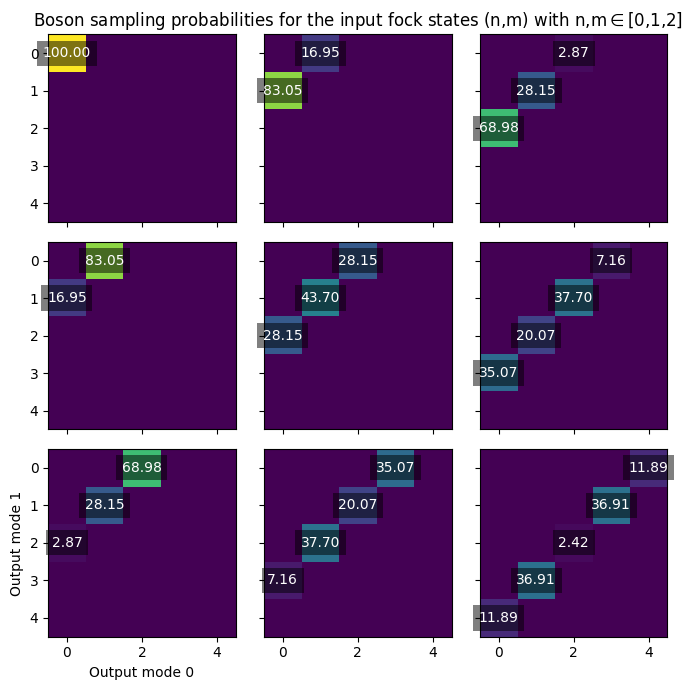

In [11]:
# set the random seed
np.random.seed(42)
cutoff_dim = 5
probs_true = np.zeros((cutoff_dim,cutoff_dim,3,3))
for i in range(3):
    for j in range(3):
        # initialize a 2 mode program
        boson_sampling = sf.Program(2)

        with boson_sampling.context as q:
            # prepare the input fock states
            Fock(i) | q[0]
            Fock(j) | q[1]

            # rotation gates
            Rgate(0.5719)  | q[0]
            Rgate(-1.9782) | q[1]

            # beamsplitter array
            BSgate(0.7804, 0.8578)  | (q[0], q[1])
            BSgate(0.563, 0.1517)   | (q[0], q[1])
            BSgate(0.4348, 0.0798)  | (q[0], q[1])

        eng = sf.Engine(backend="fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(boson_sampling)
        probs_true[:,:,i,j] = results.state.all_fock_probs()
plot_probs(probs_true)

We now turn to the 4-mode Gaussian Boson sampling formulation of the 2-mode Boson sampling problem.\
We generate the Fock states by introducing an auxiliary mode $|\tilde{0}\rangle$ for each input mode.\
To generate the two-mode squeezed vacuum states, each mode + its auxiliary is subject to the following [circuit](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.S2gate.html#details):
$$
B^\dagger(\pi/4,0)[S(r)\otimes S(-r)]B(\pi/4,0)|0,\tilde{0}\rangle = \frac{1}{\cosh(r)}\sum_{n=0}^\infty\left(-\tanh(r)\right)^n|n,\tilde{n}\rangle
$$
where $S(r)$ is a single mode squeezing operation with squeezing parameter: $r=\ln(\sqrt{2}+1)$ and $B(\pi/4,0)$ is a 50% beamsplitter.\
After this initial preparation with Gaussian states (vacuum) and Gaussian operations (squeezing and beamsplitters) the rest of the circuit remains the same. This defines a GBS problem where observing $|\tilde{1}\rangle$ in the auxiliary mode gives the same output as the Boson sampling problem with input $|1\rangle$.

In [12]:
r = np.log(np.sqrt(2)+1)
CV_boson_sampling = sf.Program(4)

with CV_boson_sampling.context as q:
    def mix(q1,q2):
        sf.ops.BSgate(np.pi/4,0) | (q1, q2)
        sf.ops.Sgate(r) | q1
        sf.ops.Sgate(-r) | q2
        sf.ops.BSgate(np.pi/4,0) | (q2, q1)

    mix(q[2],q[0])
    mix(q[3],q[1])

    # rotation gates
    Rgate(0.5719)  | q[0]
    Rgate(-1.9782) | q[1]

    # beamsplitter array
    BSgate(0.7804, 0.8578)  | (q[0], q[1])
    BSgate(0.563, 0.1517)   | (q[0], q[1])
    BSgate(0.4348, 0.0798)  | (q[0], q[1])

eng = sf.Engine(backend="fock", backend_options={"cutoff_dim": cutoff_dim})
results = eng.run(CV_boson_sampling)
probs_CV = results.state.all_fock_probs()

Of course, the heralding occurs with probability: $\prod_{i} \frac{\tanh(r)^{2n_i}}{\cosh(r)^2}$
which with the above choice for $r$ yields: $\frac{\tanh(r)^{2\cdot 0}}{\cosh(r)^2}=0.5$, $\frac{\tanh(r)^{2\cdot 1}}{\cosh(r)^2}=0.25$, $\frac{\tanh(r)^{2\cdot 2}}{\cosh(r)^2}=0.125$

Therefore, the 'rescaling' procedure below, recovers the exact probabilites:

In [13]:
rescaling = 1/np.array([[0.5,0.25,0.125]])
rescaling = np.ones((cutoff_dim,cutoff_dim,1,1))*(rescaling.T@rescaling)

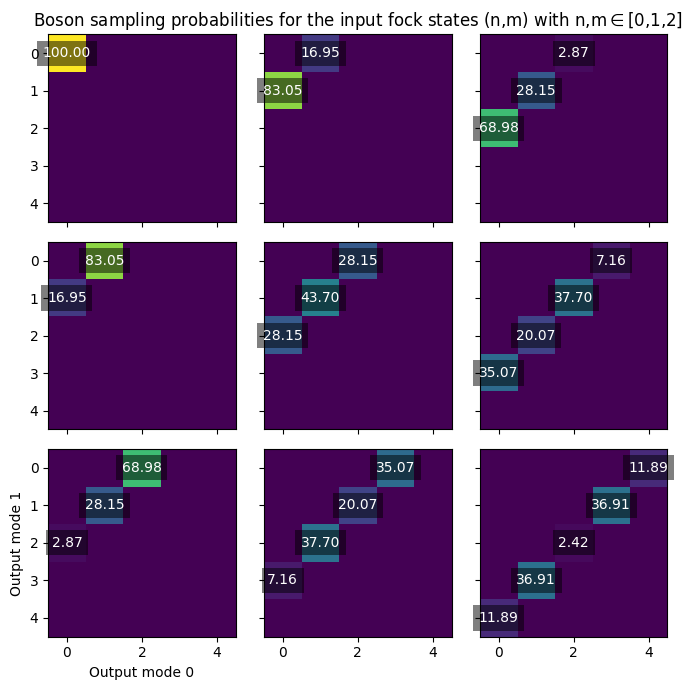

In [14]:
plot_probs(probs_CV[:,:,:3,:3]*rescaling)

To use our variational method, we first obtain the covariance matrix for the GBS problem, which in turn defines the variational Hamiltonian:

GaussianTransform([[ 0.2508  0.9455  0.1773  0.6685  0.5254 -0.8759 -0.3715  0.6193]
 [ 0.7092  0.5594  0.5015  0.3955 -1.0761  0.1613  0.7609 -0.1141]
 [ 1.      0.      1.4142  0.      0.      0.      0.      0.    ]
 [ 0.      1.      0.      1.4142  0.      0.      0.      0.    ]
 [-0.5254  0.8759 -0.3715  0.6193  0.2508  0.9455 -0.1773 -0.6685]
 [ 1.0761 -0.1613  0.7609 -0.1141  0.7092  0.5594 -0.5015 -0.3955]
 [ 0.      0.      0.      0.     -1.      0.      1.4142  0.    ]
 [ 0.      0.      0.      0.      0.     -1.      0.      1.4142]]) | (q[0], q[1], q[2], q[3])


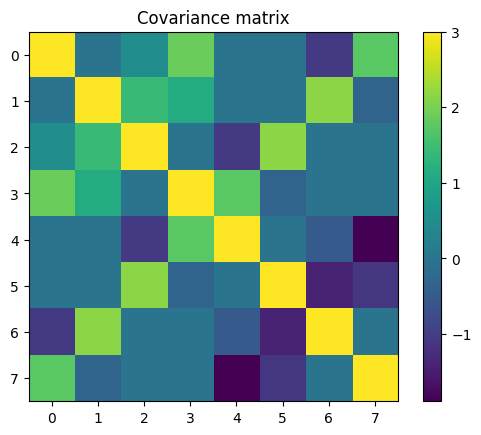

In [15]:
prog_unitary = sf.Program(4)
prog_unitary.circuit = CV_boson_sampling.circuit#[4:]
prog_compiled = prog_unitary.compile(compiler="gaussian_unitary")
prog_compiled.print()

S = prog_compiled.circuit[0].op.p[0]

cov = S@S.T #hbar = 2
# print(tw.quantum.is_pure_cov(cov))
plt.imshow((cov))
plt.title('Covariance matrix')
plt.colorbar()

We are now able to turn to our variational method.\
To this end we need to define a cutoff for the individual modes. This is done with the list 'Ds' below:

In [19]:
Ds = [8, 8, 8, 8] #[input mode 1, input mode 2, herald mode 1, herald mode 2]
print("Resulting size of the Hilbert space:", np.prod(Ds))

Resulting size of the Hilbert space: 4096


The code below creates the finite size matrix H that corresponds to the variational Hamiltonian with the cutoffs given above.

In [20]:
D = max(Ds)
N = cov.shape[0]//2

Dtmp = D + 1

a = np.diag(np.sqrt(np.arange(1, Dtmp)), 1)
X = (a + a.T)/np.sqrt(2)
X2 = X@X
P = -1j*(a - a.T)/np.sqrt(2)
P2 = P@P
XPPX = X@P + P@X
Id = np.eye(Dtmp)

def kron(*args):
    tmp_kron = [Id,]*N
    for (i, op) in args:
        tmp_kron[i] = op
    for i, Di in enumerate(Ds):
        tmp_kron[i] = tmp_kron[i][:Di,:Di]
    return reduce(np.kron, tmp_kron)

coeffs = np.linalg.inv(cov)/2

a = coeffs[:N,:N]
b = coeffs[N:,N:]
c = coeffs[:N,N:]

#################### Creation of the Hamiltonian ####################
H = 0
for i in range(N):
    op = a[i,i]*X2 + b[i,i]*P2 + c[i,i]*XPPX - Id/2
    H += kron((i,op))
for i in range(N):
    for j in range(i+1,N):
        H += 2*a[i,j]*kron((i,X),(j,X))
        H += 2*b[i,j]*kron((i,P),(j,P))
for i in range(N):
    for j in range(N):
        if i != j:
            H += 2*c[i,j]*kron((i,X),(j,P))

We can then find the ground state with our favourite eigensolver, whose amplitudes corresponds to the heralded output probabilites:

The ground state eigenvalue: [0.0739]
It should be zero in the exact case (i.e. infinite cutoff)


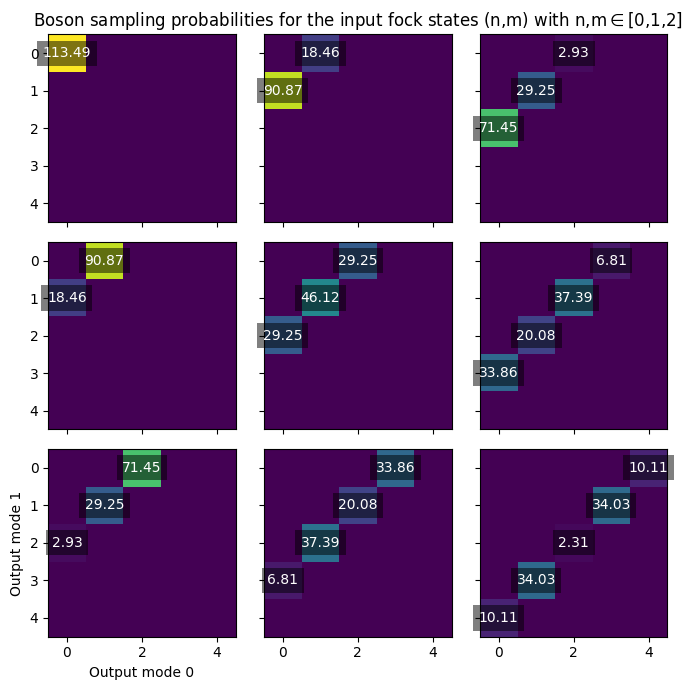

In [ ]:
if np.prod(Ds) < 3000:
    eigvals, eigvecs = np.linalg.eigh(H)
    eigval = eigvals[0]
    eigvec = eigvecs[:,0]
else:
    eigval, eigvec = sp.sparse.linalg.eigsh(H, k=1, which='SA', return_eigenvectors=True)
print("The ground state eigenvalue:", eigval)
print("It should be zero in the exact case (i.e. for an infinite cutoff)")

amps = eigvec.reshape(Ds)
probs_variational = np.abs(amps[:cutoff_dim,:cutoff_dim,:3,:3])**2 * rescaling

plot_probs(probs_variational)